Notebook to illustrate the functions and utilities present in basic_functions.py

In [1]:
from basic_functions import *

Make a z luminosity distance array that can be easily interpolated

In [2]:
z_array = np.linspace(0,10.,2000)
luminosity_distance_array = luminosity_distance(z_array, 70.5, 0.3)
cosmo_true_z_luminosity_distance_list = np.array([z_array, luminosity_distance_array])

Define parameters for a waveform

In [67]:
m1 = 1.4
m2 = 1.35
z = 3
theta = 0.1
effective_distance = np.interp(z, cosmo_true_z_luminosity_distance_list[0], cosmo_true_z_luminosity_distance_list[1])/theta
q = q_from_m1_m2(m1,m2)
lambda_tilde = lambda_tilde_from_m1_m2(m1,m2)
m_chirp = m_chirp_from_m1_m2(m1,m2)
m_chirp_z = m_chirp * (1+z)
    
keys = ['m_chirp_z', 'q', 'lambda_tilde', 'effective_distance', 'z']
values = [m_chirp_z, q, lambda_tilde, effective_distance, z]
pars = dict(zip(keys, values))
#print (lambda_tilde)

Define the detector PSD

In [33]:
freq, psd = np.loadtxt('CE_psd.txt', unpack=True)

Plot the waveform

In [34]:
waveform = Waveform(pars, freq)
waveform.plot_waveform()

ValueError: operands could not be broadcast together with shapes (3000,) (2,) 

Calcultae the SNR. For this code SNR less than 10 may create problems.

In [35]:
print(waveform.snr(psd))

1.8939816370393439


Plot log q, log lambda tilde, log luminosity distance samples

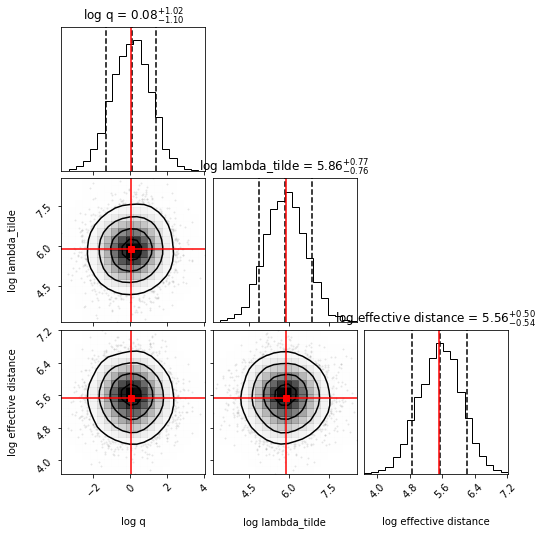

In [36]:
waveform.calculate_errors(psd)
waveform.make_log_q_log_lambda_tilde_samples()
waveform.plot_log_q_log_lambda_tilde_log_effective_distance_samples()


We make a grid of chirp mass, using log lambda tilde and log q as the axis and save it in a .txt file for reference

In [8]:
log_q_array = np.linspace(np.log(0.3),np.log(1),20)
log_lambda_tilde_array = np.linspace(4,10,20)
m_chirp_grid = m_chirp_grid_from_log_q_log_lambda_tilde(log_q_array,log_lambda_tilde_array)
np.savetxt('m_chirp_grid_using_SLY.txt', m_chirp_grid)


Make a imshow of chirp mass grid

Text(0, 0.5, 'log(lambda_tilde)')

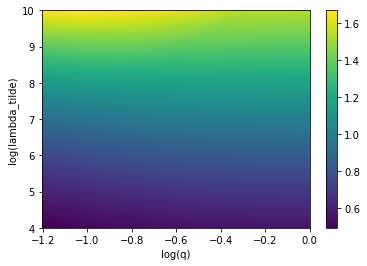

In [8]:
m_chirp_grid = np.loadtxt('m_chirp_grid_using_SLY150.txt')
plt.imshow(m_chirp_grid, extent=[np.log(0.3),np.log(1),4,10], aspect='auto')
plt.colorbar()
plt.xlabel('log(q)')
plt.ylabel('log(lambda_tilde)')

Now we look at chirp mass, log q and redshift samples

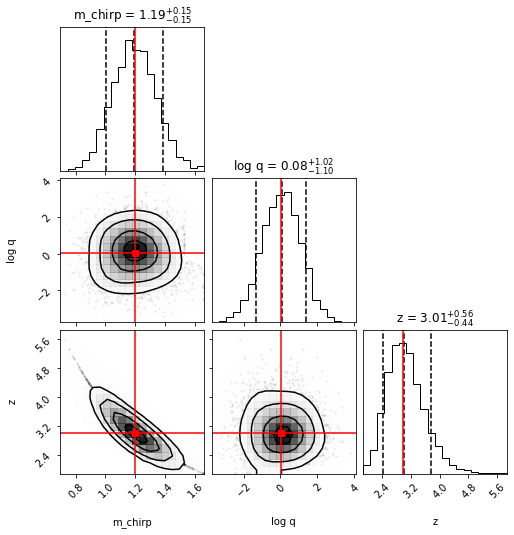

In [37]:
log_q_array = np.linspace(np.log(0.3),np.log(1),150)
log_lambda_tilde_array = np.linspace(4,10,150)
m_chirp_grid = np.loadtxt('m_chirp_grid_using_SLY150.txt')#m_chirp_grid_from_q_log_lambda_tilde(q_array,log_lambda_tilde_array)
waveform.make_z_m_chirp_samples(m_chirp_grid, log_q_array, log_lambda_tilde_array)
waveform.plot_m_chirp_log_q_z()

Lets study the SNR distribution of events

(array([7.640e+02, 2.107e+03, 3.157e+03, 4.086e+03, 4.646e+03, 4.966e+03,
        5.161e+03, 5.337e+03, 5.320e+03, 5.304e+03, 5.122e+03, 5.057e+03,
        4.576e+03, 4.347e+03, 3.948e+03, 3.754e+03, 3.394e+03, 3.024e+03,
        2.738e+03, 2.445e+03, 2.204e+03, 1.943e+03, 1.692e+03, 1.475e+03,
        1.299e+03, 1.249e+03, 1.091e+03, 8.780e+02, 8.160e+02, 7.390e+02,
        6.340e+02, 5.610e+02, 4.910e+02, 4.980e+02, 4.520e+02, 3.720e+02,
        3.690e+02, 2.950e+02, 2.460e+02, 2.430e+02, 2.560e+02, 2.020e+02,
        1.810e+02, 1.680e+02, 1.310e+02, 1.470e+02, 1.250e+02, 1.240e+02,
        1.040e+02, 1.170e+02, 8.400e+01, 8.000e+01, 9.100e+01, 7.500e+01,
        9.000e+01, 5.300e+01, 4.900e+01, 6.000e+01, 5.100e+01, 4.600e+01,
        5.200e+01, 3.800e+01, 3.900e+01, 4.100e+01, 3.900e+01, 3.700e+01,
        3.400e+01, 2.800e+01, 2.400e+01, 3.500e+01, 2.400e+01, 2.900e+01,
        1.400e+01, 1.300e+01, 2.500e+01, 2.100e+01, 1.200e+01, 1.400e+01,
        2.000e+01, 1.500e+01, 9.000e+0

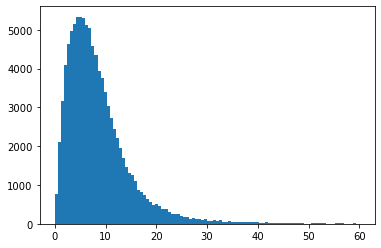

In [50]:
FNAME = 'data_seed_70.h5'
f = h5py.File(FNAME, "r")
snr = np.array(f['snr population'])
plt.hist(snr, range = (0,60), bins = 100)

In [69]:
len(np.where(snr[:10000]>10)[0])

30069

Lets have a look at first 500 samples in data_seed_70.h5



In [54]:
n_events = 1001
FNAME = 'data_seed_70.h5'
f = h5py.File(FNAME, "r")
chirp_mass_prior_bounds = np.array([1,1.4])
log_q_prior_bounds = np.log(np.array([0.7, 0.95]))
effective_distance_population = f['effective distance population'][:n_events]
z_population = f['redshift population'][:n_events]
z_measured = []
zplus1_measured = []
zplus1_error = []
z_error = []
log_effective_distance_error = []
for n_events_ in range(n_events):
    if n_events_%500 == 0: print(n_events_)
    z_samples = f['z_samples'+str(n_events_)][:]
    z_measured.append(np.median(z_samples))
    z_error.append(np.std(z_samples))
    zplus1_measured.append(np.median(1+z_samples))
    zplus1_error.append(np.std(1+z_samples))
    log_effective_distance_error.append(np.array(f['log_effective_distance_error'+str(n_events_)]))

log_effective_distance_error = np.array(log_effective_distance_error)
z_error = np.array(z_error)
z_measured = np.array(z_measured)
zplus1_error = np.array(zplus1_error)
zplus1_measured = np.array(zplus1_measured)
        

0
500
1000


Plot of $\delta$z vs z

Text(0.5, 0, 'z')

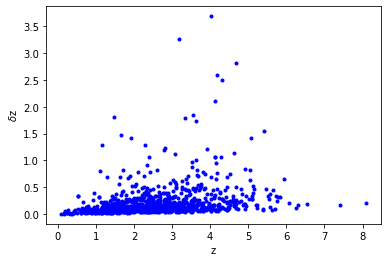

In [55]:
plt.plot(z_measured, np.array(z_error),  '.b')
plt.ylabel(r'$\delta$z')
plt.xlabel('z')

Plot of $\delta$z/z vs z

Text(0.5, 0, 'z')

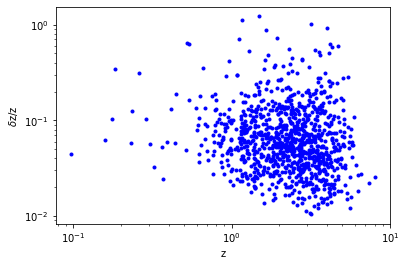

In [56]:
plt.loglog(z_measured, np.array(z_error)/np.array(z_measured),  '.b')
plt.ylabel(r'$\delta$z/z')
plt.xlabel('z')

Plot of $\frac{\delta (1+z)}{1+z}$ vs z

Text(0.5, 0, 'z')

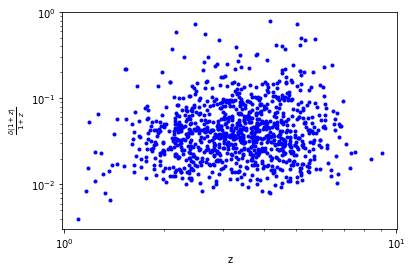

In [57]:
plt.loglog(zplus1_measured, np.array(zplus1_error)/np.array(zplus1_measured),  '.b')
plt.ylabel(r'$\frac{\delta (1+z)}{1+z}$')
plt.xlabel('z')

Check lambda_tilde interpolation

In [30]:
m1=1.2
m2 =1.
q = q_from_m1_m2(m1,m2)
mc = m_chirp_from_m1_m2(m1,m2)
lambda_tilde = lambda_tilde_from_m_chirp_q(mc , q)
print (mc)
log_q_array = np.linspace(np.log(0.3),np.log(1),150)
log_lambda_tilde_array = np.linspace(4,10,150)
m_chirp_grid = np.loadtxt('m_chirp_grid_using_SLY150.txt')
m_chirp_grid_interp = interp2d(log_q_array,log_lambda_tilde_array,m_chirp_grid)
print(m_chirp_grid_interp(np.log(q), np.log(lambda_tilde)))

0.9528492828960993
[0.95419118]
